## WHO GHO Indicators for Obesity Research

**Analysis of 3,039 available WHO indicators found 808 obesity-related indicators:**

| Category | Count | Key Examples |
|----------|-------|--------------|
| **Direct Obesity/BMI** | 29 | `NCD_BMI_30A` (adult obesity), `NCD_BMI_25C` (overweight), child malnutrition |
| **Physical Activity** | 17 | `NCD_PAC` (insufficient activity), PA guidelines, workplace initiatives |
| **Nutrition/Diet** | 76 | Minimum acceptable diet, food safety, unhealthy diet policies |
| **Diabetes/Glucose** | 22 | `NCD_GLUC_04` (raised blood glucose), diabetes testing, HbA1c |
| **Cardiovascular** | 27 | `BP_04` (hypertension), blood pressure, heart disease mortality |
| **Tobacco** | 248 | Tobacco use, advertising bans, tobacco control programs |
| **Alcohol** | 275 | Alcohol consumption, use disorders, BAC limits |
| **Socioeconomic** | 84 | Poverty (`CCO_1`), literacy, income inequality |
| **Geographic** | 27 | Urban/rural population, city coverage |
| **Healthcare** | 62 | Health expenditure, financial protection, access |

**Full list saved to:** `data/obesity_related_indicators.csv`



In [ ]:
# Setup for Google Colab
# Uncomment and edit the lines below if running in Colab:

# from google.colab import drive
# drive.mount('/content/drive')
# import os
# os.chdir('/content/drive/MyDrive/Obesity')  # Change this to your path


# Obesity — Data Collection

Download WHO Global Health Observatory indicator data, merge into a single CSV file.

**Quick Start:** Change `query` below to select indicators (e.g., `'obesity'`, `'tobacco'`, `'diabetes'`), then run all cells.

## Configuration & Setup

In [24]:
import requests
import pandas as pd
import time

query = 'NCD_BMI|obesity|overweight|physical activity|diabetes|glucose|hypertension|blood pressure|tobacco|income|poverty|education'

print(f'Query: {query}')

Query: NCD_BMI|obesity|overweight|physical activity|diabetes|glucose|hypertension|blood pressure|tobacco|income|poverty|education


## Load Existing Indicators & Filter by Query

In [ ]:
# Load indicators and existing data
from glob import glob
import numpy as np
import os

indicators_df = pd.read_csv('../data/all_who_indicators.csv')[['IndicatorCode', 'IndicatorName']].drop_duplicates()

# Load existing data (merge part files if they exist)
part_files = sorted(glob('../data/who_data_part*.csv'))
if part_files:
    combined_df = pd.concat([pd.read_csv(f) for f in part_files], ignore_index=True)
    print(f'Loaded {len(part_files)} part files')
else:
    combined_df = pd.DataFrame()
    print('No existing data')

existing_codes = set(combined_df['IndicatorCode'].unique()) if len(combined_df) > 0 else set()
print(f'Existing: {len(existing_codes)} indicators, {len(combined_df):,} rows')

# Load indicator catalog to check for indicators with no data
catalog_file = '../data/indicator_catalog.csv'
if os.path.exists(catalog_file):
    catalog_df = pd.read_csv(catalog_file)
    # Indicators with 0 rows = no data available
    no_data_indicators = set(catalog_df[catalog_df['TotalRows'] == 0]['IndicatorCode'])
    print(f'Catalog: {len(catalog_df)} tracked, {len(no_data_indicators)} with no data')
else:
    no_data_indicators = set()
    print('Catalog: not found (will be created)')

# Filter by query
query_mask = (indicators_df['IndicatorName'].str.contains(query, case=False, na=False) | 
              indicators_df['IndicatorCode'].str.contains(query, case=False, na=False))

# Exclude existing indicators AND those known to have no data
exclude_codes = existing_codes | no_data_indicators
new_df = indicators_df[query_mask][~indicators_df['IndicatorCode'].isin(exclude_codes)]

selected_indicators = new_df.to_dict('records')
blacklisted_in_query = len(no_data_indicators & set(indicators_df[query_mask]["IndicatorCode"]))
print(f'Matched: {query_mask.sum()} | Already have: {len(existing_codes)} | No data (skipped): {blacklisted_in_query} | To download: {len(new_df)}')

if len(new_df) > 0:
    print(f'\nFirst 10:\n{new_df.head(10).to_string(index=False)}')

C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\101763381.py:10: DtypeWarning: Columns (1,2,4,5,6,7,25) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.concat([pd.read_csv(f) for f in part_files], ignore_index=True)
C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\101763381.py:10: DtypeWarning: Columns (4,5,6,7,25) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.concat([pd.read_csv(f) for f in part_files], ignore_index=True)
C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\101763381.py:10: DtypeWarning: Columns (4,5,6,7,25) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.concat([pd.read_csv(f) for f in part_files], ignore_index=True)
C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\101763381.py:10: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.concat([pd.read_csv(f) for f in p

Loaded 11 part files
Existing: 411 indicators, 1,985,138 rows
Matched: 394 | To download: 69

First 10:
           IndicatorCode                                                                                                                     IndicatorName
  E20_subnational_exists                 Subnational laws or regulations exist banning some or all types of tobacco advertising, promotion and sponsorship
      EQ_OVERWEIGHTADULT                                                                                              Prevalence of overweight and obesity
FINPROTECTION_IMP_PG_310  Increase in poverty gap  due to household  health expenditures at the $3.10a day poverty line, in cents of international dollars
   O_Avail_hlthSPACEclin                                     Treatment for tobacco dependence available in health clinics or other primary care facilities
FINPROTECTION_IMP_PG_190 Increase in poverty gap  due to household  health expenditures at the $1.90 a day poverty line, 

C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\101763381.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_df = indicators_df[query_mask][~indicators_df['IndicatorCode'].isin(existing_codes)]


## Download Indicator Data

In [ ]:
# Download indicator data
all_data = []
indicator_summary = []
downloaded_indicators = {}  # Track all attempted downloads: code -> record_count

for idx, indicator in enumerate(selected_indicators, 1):
    code = indicator.get('IndicatorCode')
    name = indicator.get('IndicatorName', '')
    print(f'[{idx}/{len(selected_indicators)}] {code}...', end=' ')
    
    try:
        r = requests.get(f'https://ghoapi.azureedge.net/api/{code}', timeout=30)
        if r.status_code == 200:
            records = r.json().get('value', [])
            downloaded_indicators[code] = len(records)
            
            if len(records) == 0:
                print(f'⊘ no data')
            else:
                for rec in records:
                    rec['IndicatorCode'] = code
                    rec['IndicatorName'] = name
                all_data.extend(records)
                indicator_summary.append({'IndicatorCode': code, 'IndicatorName': name, 'NumberOfRecords': len(records)})
                print(f'✓ {len(records)}')
        else:
            print(f'✗ {r.status_code}')
    except Exception as e:
        print(f'✗ {e}')
    time.sleep(0.2)

print(f'\nDownloaded: {len(indicator_summary)} indicators with data, {len(all_data):,} records')
print(f'Empty indicators: {sum(1 for count in downloaded_indicators.values() if count == 0)}')

[1/69] E20_subnational_exists... ✓ 0
[2/69] EQ_OVERWEIGHTADULT... ✓ 0
[2/69] EQ_OVERWEIGHTADULT... ✓ 0
[3/69] FINPROTECTION_IMP_PG_310... ✓ 0
[3/69] FINPROTECTION_IMP_PG_310... ✓ 0
[4/69] O_Avail_hlthSPACEclin... ✓ 0
[4/69] O_Avail_hlthSPACEclin... ✓ 0
[5/69] FINPROTECTION_IMP_PG_190... ✓ 0
[5/69] FINPROTECTION_IMP_PG_190... ✓ 0
[6/69] obesewm... ✓ 0
[6/69] obesewm... ✓ 0
[7/69] M_Est_tob_curr_crude... ✓ 0
[7/69] M_Est_tob_curr_crude... ✓ 0
[8/69] R_admin_tax_stamps... ✓ 0
[8/69] R_admin_tax_stamps... ✓ 0
[9/69] overwgt3... ✓ 0
[9/69] overwgt3... ✓ 0
[10/69] M_smkless_prev_adult... ✓ 0
[10/69] M_smkless_prev_adult... ✓ 0
[11/69] M_smkless_prev_youth... ✓ 0
[11/69] M_smkless_prev_youth... ✓ 0
[12/69] NCD_BMI_MINUS2A... ✓ 0
[12/69] NCD_BMI_MINUS2A... ✓ 0
[13/69] M_Est_tob_daily... ✓ 0
[13/69] M_Est_tob_daily... ✓ 0
[14/69] M_Est_tob_daily_crude... ✓ 0
[14/69] M_Est_tob_daily_crude... ✓ 0
[15/69] M_smkless_def_text_adult... ✓ 0
[15/69] M_smkless_def_text_adult... ✓ 0
✓ 0
[16/69] M_smkless

## Save to CSV

In [27]:
# Save data
if len(all_data) > 0:
    import os
    
    new_df = pd.DataFrame(all_data)
    new_df['source_file'] = new_df['IndicatorCode'] + '.csv'
    
    # Combine with existing
    combined = pd.concat([combined_df, new_df], ignore_index=True)
    
    print(f'New indicators downloaded: {len(new_df["IndicatorCode"].unique())}')
    print(f'Saving combined dataset...\n')
    
    # Split and save: keep each under 75 MB, preserve indicators
    MAX_BYTES = 75 * 1024 * 1024  # 75 MB
    base_path = '../data/who_data_part'
    
    part = 1
    current_chunk = []
    current_size = 0
    
    # Process each indicator group
    for indicator_code in sorted(combined['IndicatorCode'].unique()):
        indicator_df = combined[combined['IndicatorCode'] == indicator_code]
        
        # Estimate size of this indicator's CSV data
        csv_text = indicator_df.to_csv(index=False, header=False)
        indicator_size = len(csv_text.encode('utf-8'))
        
        # If adding this indicator would exceed limit and we have data, save current chunk
        if current_size + indicator_size > MAX_BYTES and len(current_chunk) > 0:
            chunk_df = pd.concat(current_chunk, ignore_index=True)
            out_file = f'{base_path}{part}.csv'
            chunk_df.to_csv(out_file, index=False)
            file_size = os.path.getsize(out_file)
            print(f'Saved part{part}: {len(chunk_df):,} rows, {file_size/1024/1024:.2f} MB')
            
            part += 1
            current_chunk = []
            current_size = 0
        
        # Add this indicator to current chunk
        current_chunk.append(indicator_df)
        current_size += indicator_size
    
    # Save final chunk if any data remains
    if len(current_chunk) > 0:
        chunk_df = pd.concat(current_chunk, ignore_index=True)
        out_file = f'{base_path}{part}.csv'
        chunk_df.to_csv(out_file, index=False)
        file_size = os.path.getsize(out_file)
        print(f'Saved part{part}: {len(chunk_df):,} rows, {file_size/1024/1024:.2f} MB')
    
    print(f'\n✓ Total: {len(combined):,} rows, {combined["IndicatorCode"].nunique()} indicators, {part} part files')
    
    # Summary
    summary = combined.groupby('source_file').size().reset_index(name='rows')
    summary.to_csv('../data/combined_summary.csv', index=False)
else:
    print('No new data to save - skipping file write')

No new data to save - skipping file write


## View Results

## Create Indicator Catalog

## Create Summary for Obesity-Only Dataset

In [28]:
# Create summary for the obesity-only filtered dataset
import os

obesity_file = '../data/who_data_obesity.csv'

if not os.path.exists(obesity_file):
    print('who_data_obesity.csv not found')
else:
    obesity_df = pd.read_csv(obesity_file)
    
    # Create indicator summary
    obesity_summary = obesity_df.groupby(['IndicatorCode', 'IndicatorName']).agg({
        'IndicatorCode': 'count'  # count rows
    }).rename(columns={'IndicatorCode': 'TotalRows'}).reset_index()
    obesity_summary = obesity_summary.sort_values('TotalRows', ascending=False)
    
    # Save summary
    obesity_summary.to_csv('../data/obesity_dataset_summary.csv', index=False)
    
    # Get file stats
    file_size = os.path.getsize(obesity_file) / 1024 / 1024
    
    print(f'✓ Obesity-only dataset summary')
    print(f'  File: who_data_obesity.csv ({file_size:.2f} MB)')
    print(f'  Total rows: {len(obesity_df):,}')
    print(f'  Indicators: {obesity_df["IndicatorCode"].nunique()}')
    print(f'  Countries: {obesity_df["SpatialDim"].nunique()}')
    print(f'  Summary saved to: data/obesity_dataset_summary.csv')
    
    print(f'\nTop 10 obesity indicators by row count:')
    print(obesity_summary.head(10).to_string(index=False))
    
    # Show indicator categories
    print(f'\n\nSample indicator breakdown:')
    categories = {
        'BMI/Obesity': obesity_df[obesity_df['IndicatorCode'].str.contains('BMI|obesity|overweight', case=False, na=False)]['IndicatorCode'].nunique(),
        'Physical Activity': obesity_df[obesity_df['IndicatorCode'].str.contains('PAC|physical', case=False, na=False)]['IndicatorCode'].nunique(),
        'Diabetes': obesity_df[obesity_df['IndicatorCode'].str.contains('diabetes|glucose|GLUC', case=False, na=False)]['IndicatorCode'].nunique(),
        'Cardiovascular': obesity_df[obesity_df['IndicatorCode'].str.contains('BP|hypertension|cardio', case=False, na=False)]['IndicatorCode'].nunique(),
    }
    for cat, count in categories.items():
        if count > 0:
            print(f'  {cat}: {count} indicators')

C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\2695805949.py:9: DtypeWarning: Columns (1,2,6,7,25) have mixed types. Specify dtype option on import or set low_memory=False.
  obesity_df = pd.read_csv(obesity_file)


✓ Obesity-only dataset summary
  File: who_data_obesity.csv (23.28 MB)
  Total rows: 71,614
  Indicators: 26
  Countries: 220
  Summary saved to: data/obesity_dataset_summary.csv

Top 10 obesity indicators by row count:
                          IndicatorCode                                                                                                             IndicatorName  TotalRows
                            NCD_BMI_18C                                                     Prevalence of underweight among adults, BMI < 18 (crude estimate) (%)      20790
                      NCD_HYP_CONTROL_C Hypertension: effective treatment coverage (controlled hypertension) among adults aged 30-79 with hypertension, crude (%)      19170
TOBACCO_MPOWER_P2_SMOKEFREEPLACEDETAILS                                                  Tobacco Protect people: P2 smoke-free places, additional characteristics      13650
                          SA_0000001823                                              Alc

In [ ]:
# Create comprehensive indicator catalog showing all indicators across all part files
from glob import glob
import os

part_files = sorted(glob('../data/who_data_part*.csv'))

if not part_files:
    print('No part files found')
else:
    # Collect indicator info from each part file
    catalog_data = []
    
    for part_file in part_files:
        part_name = os.path.basename(part_file)
        df = pd.read_csv(part_file)
        
        # Group by indicator
        indicator_groups = df.groupby(['IndicatorCode', 'IndicatorName']).size().reset_index(name='rows')
        indicator_groups['part_file'] = part_name
        indicator_groups['file_size_mb'] = os.path.getsize(part_file) / 1024 / 1024
        
        catalog_data.append(indicator_groups)
    
    # Combine all catalog data
    full_catalog = pd.concat(catalog_data, ignore_index=True)
    
    # Create summary by indicator (across all files)
    indicator_summary = full_catalog.groupby(['IndicatorCode', 'IndicatorName']).agg({
        'rows': 'sum',
        'part_file': lambda x: ', '.join(sorted(set(x)))
    }).reset_index()
    indicator_summary.columns = ['IndicatorCode', 'IndicatorName', 'TotalRows', 'PartFiles']
    
    # Add indicators that were downloaded but had no data (if tracked in this session)
    if 'downloaded_indicators' in globals():
        for code, count in downloaded_indicators.items():
            if count == 0 and code not in indicator_summary['IndicatorCode'].values:
                # Get indicator name
                ind_name = indicators_df[indicators_df['IndicatorCode'] == code]['IndicatorName'].iloc[0] if code in indicators_df['IndicatorCode'].values else 'Unknown'
                new_row = pd.DataFrame([{'IndicatorCode': code, 'IndicatorName': ind_name, 'TotalRows': 0, 'PartFiles': 'none'}])
                indicator_summary = pd.concat([indicator_summary, new_row], ignore_index=True)
        print(f'Added {sum(1 for c in downloaded_indicators.values() if c == 0)} empty indicators to catalog')
    
    indicator_summary = indicator_summary.sort_values('TotalRows', ascending=False)
    
    # Save catalog
    indicator_summary.to_csv('../data/indicator_catalog.csv', index=False)
    print(f'✓ Saved indicator catalog: {len(indicator_summary)} indicators ({sum(indicator_summary["TotalRows"] == 0)} with no data)')
    print(f'  File: data/indicator_catalog.csv')
    
    # Display top indicators
    print(f'\nTop 10 indicators by row count:')
    print(indicator_summary[indicator_summary['TotalRows'] > 0].head(10).to_string(index=False))
    
    # Show empty indicators if any
    empty_count = sum(indicator_summary['TotalRows'] == 0)
    if empty_count > 0:
        print(f'\n⊘ {empty_count} indicators with no data (will be skipped in future downloads)')
    
    # File distribution summary
    print(f'\nPart file summary:')
    for part_file in part_files:
        part_name = os.path.basename(part_file)
        file_size = os.path.getsize(part_file) / 1024 / 1024
        df = pd.read_csv(part_file)
        n_indicators = df['IndicatorCode'].nunique()
        print(f'  {part_name}: {len(df):,} rows, {n_indicators} indicators, {file_size:.2f} MB')

C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\3796668442.py:15: DtypeWarning: Columns (1,2,4,5,6,7,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(part_file)
C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\3796668442.py:15: DtypeWarning: Columns (4,5,6,7,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(part_file)
C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\3796668442.py:15: DtypeWarning: Columns (4,5,6,7,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(part_file)
C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\3796668442.py:15: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(part_file)
C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\3796668442.py:15: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df =

✓ Saved indicator catalog: 410 indicators
  File: data/indicator_catalog.csv

Top 10 indicators by row count:
                    IndicatorCode                                                                                                               IndicatorName  TotalRows           PartFiles
                    NCD_BMI_MEANC                                                                                      Mean BMI (kg/m&#xb2;) (crude estimate)     115404  who_data_part3.csv
PHE_HHAIR_PROP_POP_CATEGORY_FUELS                      Proportion of population with primary reliance on fuels and technologies for cooking, by fuel type (%)     102204  who_data_part8.csv
                          MORTADO                                                                   Adolescent mortality rate (per 1 000 age specific cohort)      76194  who_data_part2.csv
            NUTRITION_ANT_WHZ_NE2              Overweight prevalence among children under 5 years of age (% weight-for-height >+2 SD),

C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\3796668442.py:49: DtypeWarning: Columns (1,2,4,5,6,7,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(part_file)


  who_data_part1.csv: 166,345 rows, 121 indicators, 52.32 MB


C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\3796668442.py:49: DtypeWarning: Columns (4,5,6,7,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(part_file)


  who_data_part10.csv: 230,505 rows, 73 indicators, 71.32 MB
  who_data_part11.csv: 57,704 rows, 4 indicators, 18.01 MB
  who_data_part11.csv: 57,704 rows, 4 indicators, 18.01 MB


C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\3796668442.py:49: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(part_file)


  who_data_part2.csv: 215,517 rows, 13 indicators, 70.01 MB


C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\3796668442.py:49: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(part_file)


  who_data_part3.csv: 224,387 rows, 4 indicators, 69.25 MB


C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\3796668442.py:49: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(part_file)


  who_data_part4.csv: 179,124 rows, 43 indicators, 62.98 MB


C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\3796668442.py:49: DtypeWarning: Columns (0,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(part_file)


  who_data_part5.csv: 228,240 rows, 11 indicators, 70.30 MB


C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\3796668442.py:49: DtypeWarning: Columns (0,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(part_file)


  who_data_part6.csv: 167,679 rows, 14 indicators, 53.54 MB


C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\3796668442.py:49: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(part_file)


  who_data_part7.csv: 98,686 rows, 18 indicators, 41.59 MB


C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\3796668442.py:49: DtypeWarning: Columns (0,1,2,6,7,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(part_file)


  who_data_part8.csv: 199,241 rows, 92 indicators, 73.32 MB
  who_data_part9.csv: 217,710 rows, 18 indicators, 73.88 MB
  who_data_part9.csv: 217,710 rows, 18 indicators, 73.88 MB


C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\3796668442.py:49: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(part_file)


In [30]:
# View results
part_files = sorted(glob('../data/who_data_part*.csv'))
final = pd.concat([pd.read_csv(f) for f in part_files], ignore_index=True)
print(f'Shape: {final.shape} | Indicators: {final["IndicatorCode"].nunique()}')
print(f'\nSample:\n{final.head()}')

C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\3229339462.py:3: DtypeWarning: Columns (1,2,4,5,6,7,25) have mixed types. Specify dtype option on import or set low_memory=False.
  final = pd.concat([pd.read_csv(f) for f in part_files], ignore_index=True)
C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\3229339462.py:3: DtypeWarning: Columns (4,5,6,7,25) have mixed types. Specify dtype option on import or set low_memory=False.
  final = pd.concat([pd.read_csv(f) for f in part_files], ignore_index=True)
C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\3229339462.py:3: DtypeWarning: Columns (4,5,6,7,25) have mixed types. Specify dtype option on import or set low_memory=False.
  final = pd.concat([pd.read_csv(f) for f in part_files], ignore_index=True)
C:\Users\Jack\AppData\Local\Temp\ipykernel_35796\3229339462.py:3: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  final = pd.concat([pd.read_csv(f) for f in part_files], ignore_index

Shape: (1985138, 28) | Indicators: 411

Sample:
  Comments DataSourceDim DataSourceDimType                       Date  \
0      NaN           NaN               NaN  2019-01-07T11:45:40+01:00   
1      NaN           NaN               NaN  2019-01-07T11:45:40+01:00   
2      NaN           NaN               NaN  2019-01-07T11:45:40+01:00   
3      NaN           NaN               NaN  2019-01-07T11:45:40+01:00   
4      NaN           NaN               NaN  2019-01-07T11:45:40+01:00   

                                         Dim1          Dim1Type Dim2 Dim2Type  \
0           AMRGLASSCATEGORY_AMRGLASS_UNKNOWN  AMRGLASSCATEGORY  NaN      NaN   
1           AMRGLASSCATEGORY_AMRGLASS_UNKNOWN  AMRGLASSCATEGORY  NaN      NaN   
2  AMRGLASSCATEGORY_AMRGLASS_PROVIDEDTOLABS06  AMRGLASSCATEGORY  NaN      NaN   
3           AMRGLASSCATEGORY_AMRGLASS_UNKNOWN  AMRGLASSCATEGORY  NaN      NaN   
4           AMRGLASSCATEGORY_AMRGLASS_UNKNOWN  AMRGLASSCATEGORY  NaN      NaN   

   Dim3  Dim3Type  ...  Pa

In [31]:
# Data quality
print('=== DATA QUALITY ===\n')
final.info()

print('\n=== MISSING VALUES ===\n')
missing = final.isnull().sum()[lambda x: x > 0].sort_values(ascending=False)
print(missing if len(missing) > 0 else 'None')

print('\n=== STATISTICS ===\n')
print(final.describe())

=== DATA QUALITY ===

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1985138 entries, 0 to 1985137
Data columns (total 28 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Comments            object 
 1   DataSourceDim       object 
 2   DataSourceDimType   object 
 3   Date                object 
 4   Dim1                object 
 5   Dim1Type            object 
 6   Dim2                object 
 7   Dim2Type            object 
 8   Dim3                float64
 9   Dim3Type            float64
 10  High                float64
 11  Id                  float64
 12  IndicatorCode       object 
 13  IndicatorName       object 
 14  Low                 float64
 15  NumberOfRecords     float64
 16  NumericValue        float64
 17  ParentLocation      object 
 18  ParentLocationCode  object 
 19  SpatialDim          object 
 20  SpatialDimType      object 
 21  TimeDim             float64
 22  TimeDimType         object 
 23  TimeDimensionBegin  object 
 24  Ti

Top 20 countries:
SpatialDim
PER    16190
IDN    12251
SEN    12170
BGD    11721
MLI    11377
GHA    11355
VNM    11352
NGA    11343
TZA    11188
DOM    11124
ZWE    11099
NPL    11064
THA    11055
BFA    11045
MWI    11041
PHL    11023
JAM    11006
UGA    10979
NER    10962
ARM    10901
dtype: int64


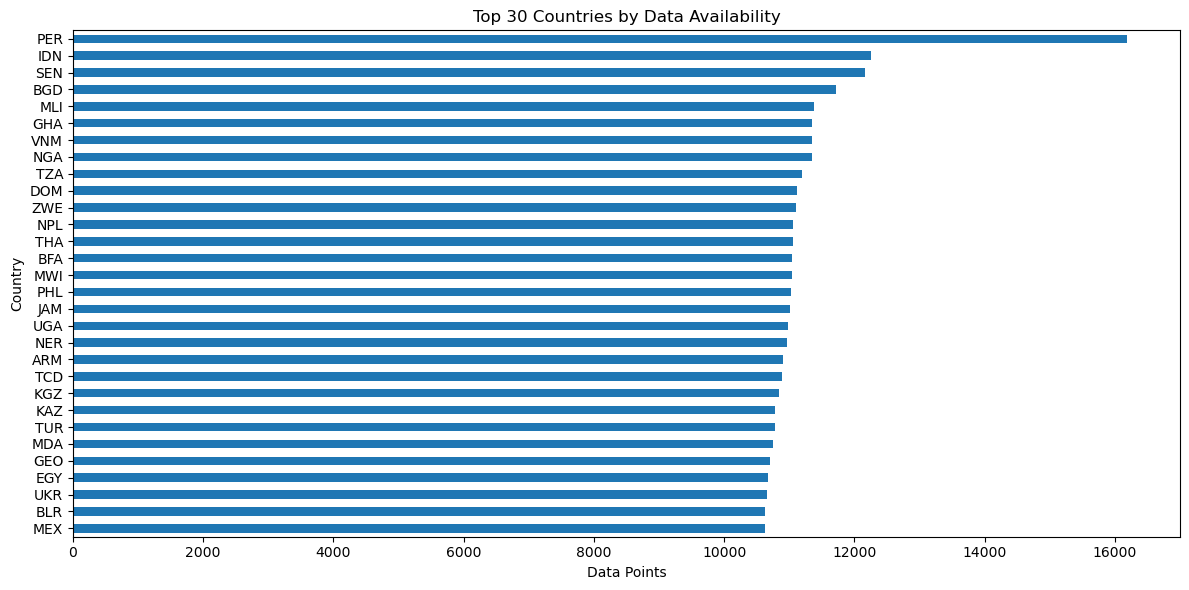


Total: 341 countries


In [32]:
# Country data availability
import matplotlib.pyplot as plt

country_data = final.groupby('SpatialDim').size().sort_values(ascending=False)
print(f'Top 20 countries:\n{country_data.head(20)}')

fig, ax = plt.subplots(figsize=(12, 6))
country_data.head(30).plot(kind='barh', ax=ax)
ax.set_xlabel('Data Points')
ax.set_ylabel('Country')
ax.set_title('Top 30 Countries by Data Availability')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print(f'\nTotal: {len(country_data)} countries')

## 📊 Comprehensive Indicator Analysis & Visualizations

In [33]:
# Dataset Overview Dashboard
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

print('=' * 80)
print('DATASET OVERVIEW'.center(80))
print('=' * 80)

# Basic statistics
total_rows = len(final)
total_indicators = final['IndicatorCode'].nunique()
total_countries = final['SpatialDim'].nunique()
year_range = f"{final['TimeDim'].min()} - {final['TimeDim'].max()}"

print(f'\n📈 Data Summary:')
print(f'  Total Records: {total_rows:,}')
print(f'  Unique Indicators: {total_indicators}')
print(f'  Countries/Regions: {total_countries}')
print(f'  Year Range: {year_range}')
print(f'  Columns: {final.shape[1]}')

# Data completeness
print(f'\n📊 Data Completeness:')
completeness = (1 - final.isnull().sum() / len(final)) * 100
top_complete = completeness.sort_values(ascending=False).head(10)
for col, pct in top_complete.items():
    print(f'  {col}: {pct:.1f}%')

# Temporal coverage
print(f'\n📅 Temporal Distribution:')
year_counts = final['TimeDim'].value_counts().sort_index()
print(f'  Most data from: {year_counts.idxmax()} ({year_counts.max():,} records)')
print(f'  Years with data: {len(year_counts)}')

print('\n' + '=' * 80)

                                DATASET OVERVIEW                                

📈 Data Summary:
  Total Records: 1,985,138
  Unique Indicators: 411
  Countries/Regions: 341
  Year Range: 1974.0 - 2030.0
  Columns: 28

📊 Data Completeness:

📈 Data Summary:
  Total Records: 1,985,138
  Unique Indicators: 411
  Countries/Regions: 341
  Year Range: 1974.0 - 2030.0
  Columns: 28

📊 Data Completeness:
  source_file: 100.0%
  IndicatorCode: 100.0%
  Date: 100.0%
  Id: 100.0%
  TimeDimensionBegin: 100.0%
  SpatialDimType: 100.0%
  TimeDimType: 100.0%
  TimeDim: 100.0%
  SpatialDim: 100.0%
  TimeDimensionEnd: 100.0%

📅 Temporal Distribution:
  Most data from: 2014.0 (107,211 records)
  Years with data: 53

  source_file: 100.0%
  IndicatorCode: 100.0%
  Date: 100.0%
  Id: 100.0%
  TimeDimensionBegin: 100.0%
  SpatialDimType: 100.0%
  TimeDimType: 100.0%
  TimeDim: 100.0%
  SpatialDim: 100.0%
  TimeDimensionEnd: 100.0%

📅 Temporal Distribution:
  Most data from: 2014.0 (107,211 records)
  Year

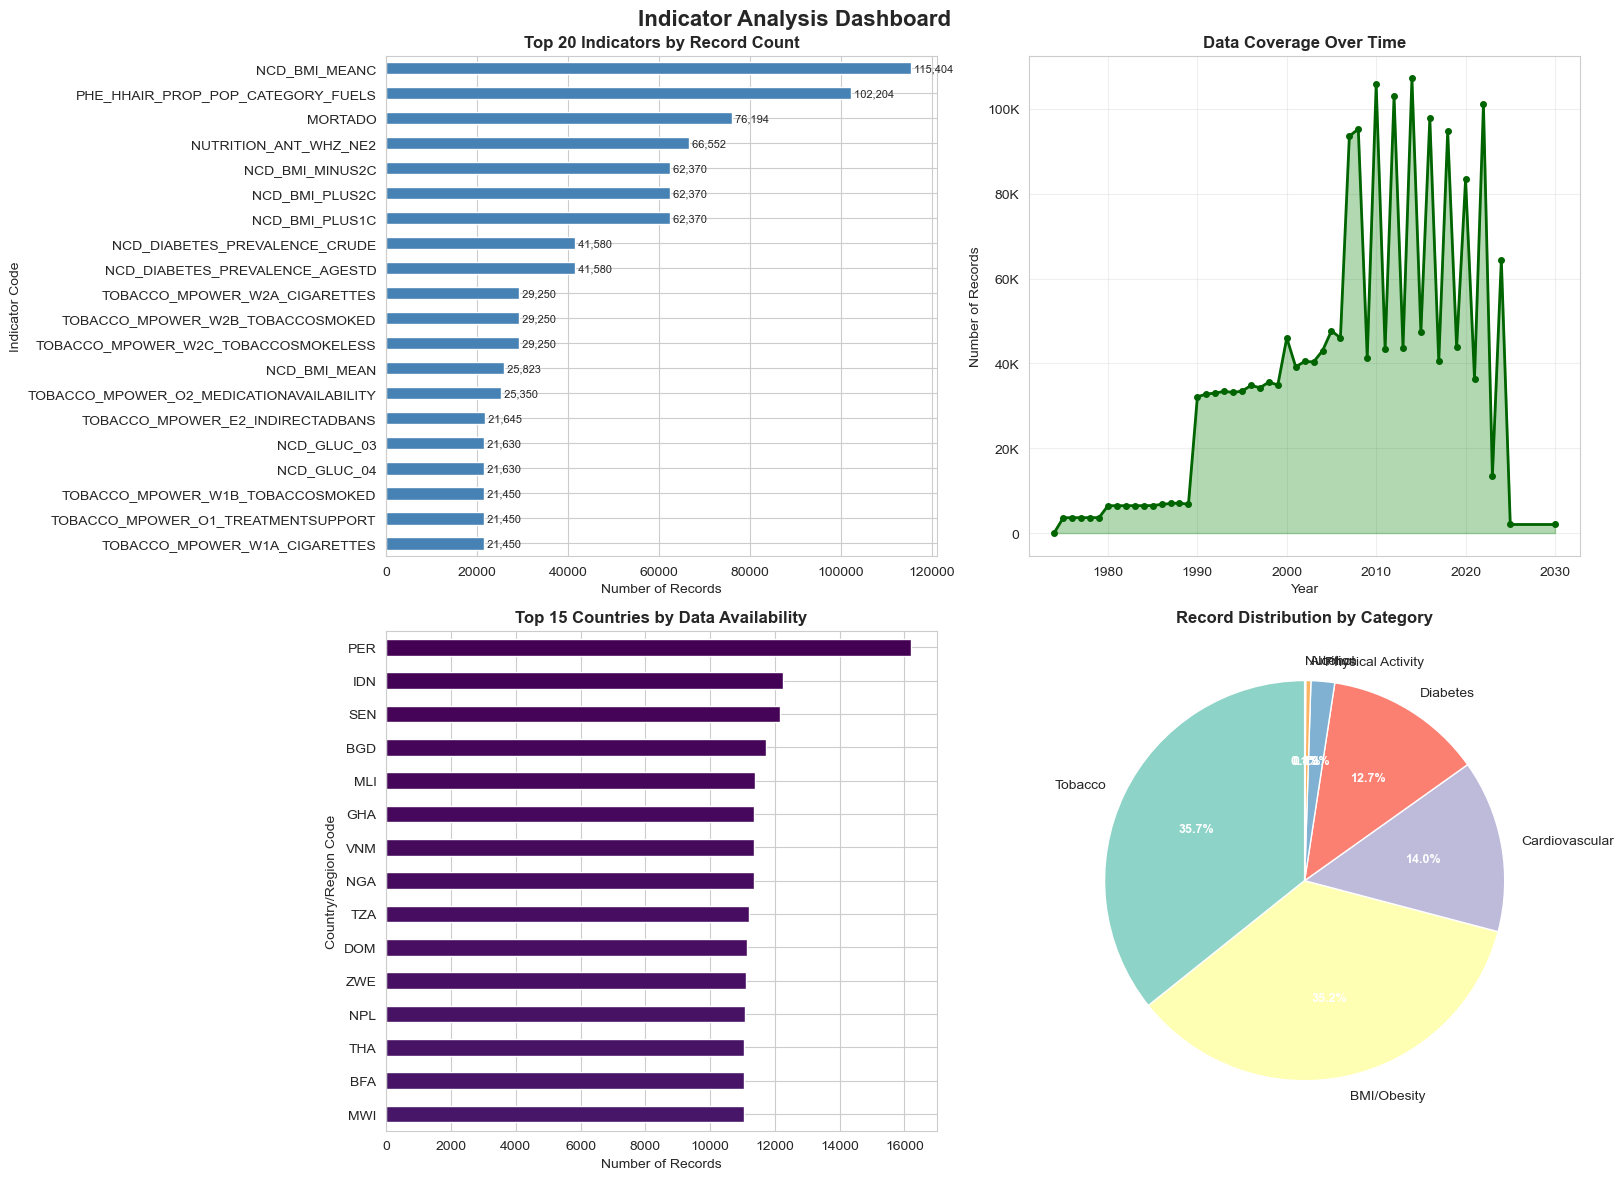


✓ Generated comprehensive indicator analysis dashboard


In [34]:
# Top Indicators by Data Volume
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Indicator Analysis Dashboard', fontsize=16, fontweight='bold')

# 1. Top 20 indicators by record count
ax1 = axes[0, 0]
top_indicators = final['IndicatorCode'].value_counts().head(20)
top_indicators.plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_xlabel('Number of Records', fontsize=10)
ax1.set_ylabel('Indicator Code', fontsize=10)
ax1.set_title('Top 20 Indicators by Record Count', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
for i, v in enumerate(top_indicators.values):
    ax1.text(v, i, f' {v:,}', va='center', fontsize=8)

# 2. Data distribution over time
ax2 = axes[0, 1]
year_dist = final.groupby('TimeDim').size()
ax2.plot(year_dist.index, year_dist.values, marker='o', linewidth=2, markersize=4, color='darkgreen')
ax2.fill_between(year_dist.index, year_dist.values, alpha=0.3, color='green')
ax2.set_xlabel('Year', fontsize=10)
ax2.set_ylabel('Number of Records', fontsize=10)
ax2.set_title('Data Coverage Over Time', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x/1000)}K' if x >= 1000 else str(int(x))))

# 3. Top countries by data availability
ax3 = axes[1, 0]
top_countries = final['SpatialDim'].value_counts().head(15)
colors = plt.cm.viridis(range(len(top_countries)))
top_countries.plot(kind='barh', ax=ax3, color=colors)
ax3.set_xlabel('Number of Records', fontsize=10)
ax3.set_ylabel('Country/Region Code', fontsize=10)
ax3.set_title('Top 15 Countries by Data Availability', fontsize=12, fontweight='bold')
ax3.invert_yaxis()

# 4. Indicator category distribution (if IndicatorName exists)
ax4 = axes[1, 1]
if 'IndicatorName' in final.columns:
    # Extract key categories from indicator names
    categories = {
        'BMI/Obesity': final['IndicatorName'].str.contains('BMI|obesity|overweight', case=False, na=False).sum(),
        'Diabetes': final['IndicatorName'].str.contains('diabetes|glucose', case=False, na=False).sum(),
        'Physical Activity': final['IndicatorName'].str.contains('physical activity|exercise', case=False, na=False).sum(),
        'Cardiovascular': final['IndicatorName'].str.contains('blood pressure|hypertension|cardiovascular', case=False, na=False).sum(),
        'Tobacco': final['IndicatorName'].str.contains('tobacco|smoking', case=False, na=False).sum(),
        'Alcohol': final['IndicatorName'].str.contains('alcohol', case=False, na=False).sum(),
        'Nutrition': final['IndicatorName'].str.contains('nutrition|diet|food', case=False, na=False).sum(),
    }
    cat_data = pd.Series(categories).sort_values(ascending=False)
    colors_pie = plt.cm.Set3(range(len(cat_data)))
    wedges, texts, autotexts = ax4.pie(cat_data.values, labels=cat_data.index, autopct='%1.1f%%',
                                        colors=colors_pie, startangle=90)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(9)
    ax4.set_title('Record Distribution by Category', fontsize=12, fontweight='bold')
else:
    ax4.text(0.5, 0.5, 'IndicatorName column not available', ha='center', va='center')
    ax4.set_title('Category Distribution (N/A)', fontsize=12)

plt.tight_layout()
plt.show()

print(f'\n✓ Generated comprehensive indicator analysis dashboard')

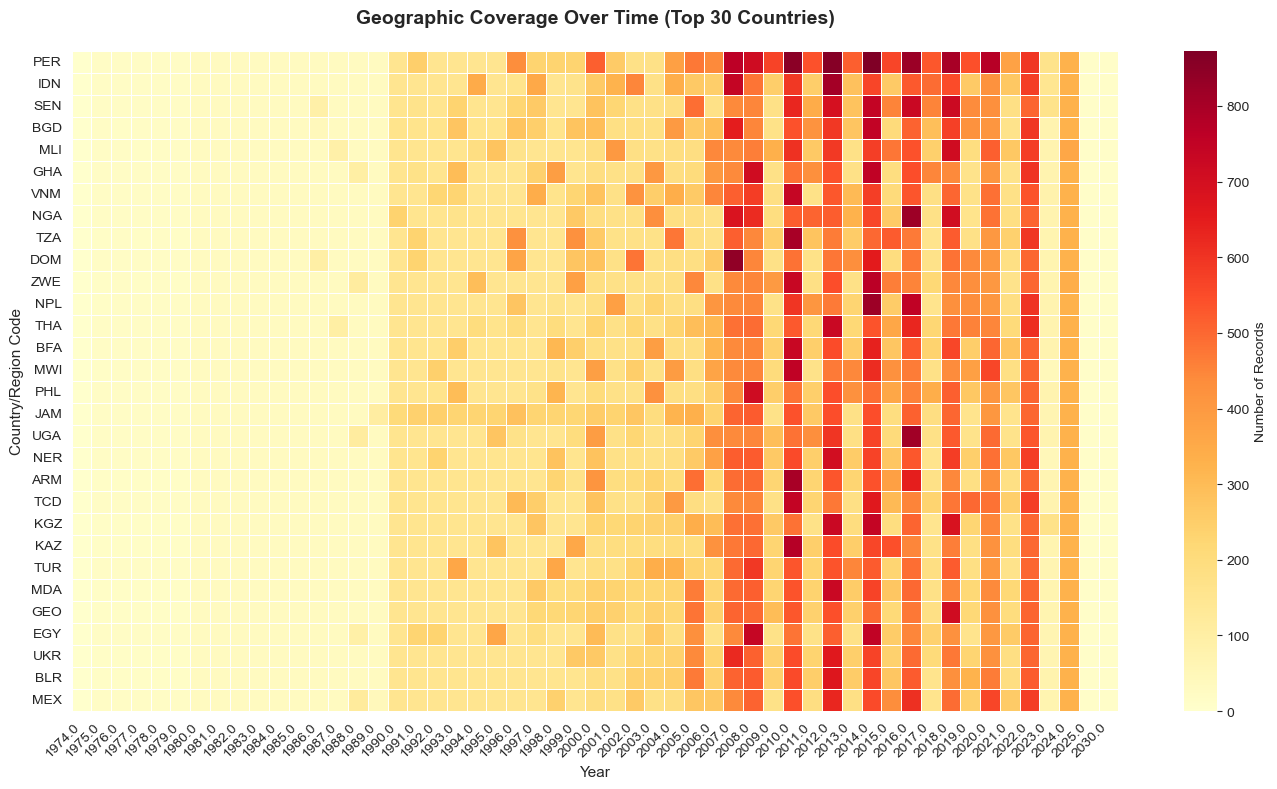

✓ Generated geographic coverage heatmap for 30 countries


In [35]:
# Geographic Coverage Heatmap
fig, ax = plt.subplots(figsize=(14, 8))

# Create a matrix of country vs year
country_year = final.groupby(['SpatialDim', 'TimeDim']).size().unstack(fill_value=0)

# Select top 30 countries by total data volume
top_30_countries = final['SpatialDim'].value_counts().head(30).index
country_year_top = country_year.loc[top_30_countries]

# Create heatmap
sns.heatmap(country_year_top, cmap='YlOrRd', cbar_kws={'label': 'Number of Records'},
            linewidths=0.5, ax=ax)
ax.set_title('Geographic Coverage Over Time (Top 30 Countries)', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Year', fontsize=11)
ax.set_ylabel('Country/Region Code', fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f'✓ Generated geographic coverage heatmap for {len(top_30_countries)} countries')

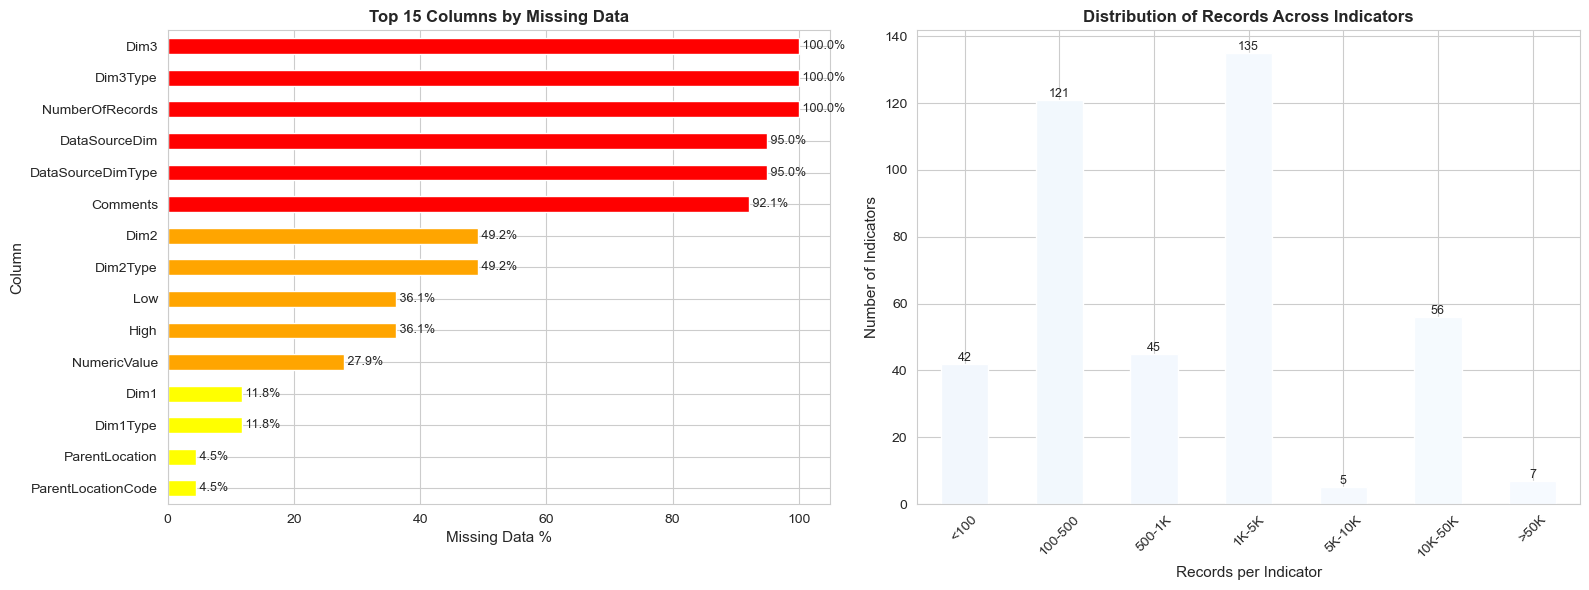

✓ Generated data quality and distribution analysis


In [36]:
# Data Quality & Completeness Analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Missing data by column
ax1 = axes[0]
missing_pct = (final.isnull().sum() / len(final) * 100).sort_values(ascending=False)
missing_pct_top = missing_pct[missing_pct > 0].head(15)

if len(missing_pct_top) > 0:
    colors = ['red' if x > 50 else 'orange' if x > 25 else 'yellow' for x in missing_pct_top.values]
    missing_pct_top.plot(kind='barh', ax=ax1, color=colors)
    ax1.set_xlabel('Missing Data %', fontsize=11)
    ax1.set_ylabel('Column', fontsize=11)
    ax1.set_title('Top 15 Columns by Missing Data', fontsize=12, fontweight='bold')
    ax1.invert_yaxis()
    for i, v in enumerate(missing_pct_top.values):
        ax1.text(v, i, f' {v:.1f}%', va='center', fontsize=9)
else:
    ax1.text(0.5, 0.5, 'No missing data found!', ha='center', va='center', fontsize=14)
    ax1.set_title('Missing Data Analysis', fontsize=12, fontweight='bold')

# 2. Records per indicator distribution
ax2 = axes[1]
records_per_indicator = final['IndicatorCode'].value_counts()
bins = [0, 100, 500, 1000, 5000, 10000, 50000, records_per_indicator.max()]
labels = ['<100', '100-500', '500-1K', '1K-5K', '5K-10K', '10K-50K', '>50K']
indicator_dist = pd.cut(records_per_indicator, bins=bins, labels=labels).value_counts().sort_index()

colors_bar = plt.cm.Blues(range(len(indicator_dist), 0, -1))
indicator_dist.plot(kind='bar', ax=ax2, color=colors_bar)
ax2.set_xlabel('Records per Indicator', fontsize=11)
ax2.set_ylabel('Number of Indicators', fontsize=11)
ax2.set_title('Distribution of Records Across Indicators', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
for i, v in enumerate(indicator_dist.values):
    ax2.text(i, v, f'{v}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print(f'✓ Generated data quality and distribution analysis')

In [37]:
# Summary Report Card
print('\n' + '=' * 80)
print('DATASET SUMMARY REPORT'.center(80))
print('=' * 80)

# Key metrics
print(f'\n📊 KEY METRICS:')
print(f'  ├─ Total Records: {len(final):,}')
print(f'  ├─ Unique Indicators: {final["IndicatorCode"].nunique()}')
print(f'  ├─ Countries/Regions: {final["SpatialDim"].nunique()}')
print(f'  ├─ Time Span: {final["TimeDim"].min()} to {final["TimeDim"].max()} ({final["TimeDim"].max() - final["TimeDim"].min()} years)')
print(f'  └─ Average Records per Indicator: {len(final) / final["IndicatorCode"].nunique():.0f}')

# Top indicators
print(f'\n🏆 TOP 5 INDICATORS BY VOLUME:')
for i, (code, count) in enumerate(final['IndicatorCode'].value_counts().head(5).items(), 1):
    indicator_name = final[final['IndicatorCode'] == code]['IndicatorName'].iloc[0] if 'IndicatorName' in final.columns else 'N/A'
    print(f'  {i}. {code}: {count:,} records')
    if indicator_name != 'N/A':
        print(f'     "{indicator_name[:70]}..."' if len(indicator_name) > 70 else f'     "{indicator_name}"')

# Geographic coverage
print(f'\n🌍 GEOGRAPHIC COVERAGE:')
top_5_countries = final['SpatialDim'].value_counts().head(5)
for i, (country, count) in enumerate(top_5_countries.items(), 1):
    print(f'  {i}. {country}: {count:,} records ({count/len(final)*100:.1f}%)')

# Temporal coverage
print(f'\n📅 TEMPORAL DISTRIBUTION:')
recent_years = final[final['TimeDim'] >= 2020]['TimeDim'].value_counts().sort_index()
if len(recent_years) > 0:
    print(f'  Recent data (2020+): {recent_years.sum():,} records across {len(recent_years)} years')
    print(f'  Most recent year with data: {final["TimeDim"].max()}')
else:
    print(f'  No data from 2020 onwards')
print(f'  Years with most data: {final["TimeDim"].value_counts().head(3).to_dict()}')

# Data quality score
completeness_score = (1 - final.isnull().sum().sum() / (len(final) * len(final.columns))) * 100
print(f'\n✅ DATA QUALITY SCORE: {completeness_score:.1f}% complete')

print('\n' + '=' * 80)
print('Report generated successfully!'.center(80))
print('=' * 80 + '\n')


                             DATASET SUMMARY REPORT                             

📊 KEY METRICS:
  ├─ Total Records: 1,985,138
  ├─ Unique Indicators: 411
  ├─ Countries/Regions: 341  ├─ Countries/Regions: 341
  ├─ Time Span: 1974.0 to 2030.0 (56.0 years)
  └─ Average Records per Indicator: 4830

🏆 TOP 5 INDICATORS BY VOLUME:

  ├─ Time Span: 1974.0 to 2030.0 (56.0 years)
  └─ Average Records per Indicator: 4830

🏆 TOP 5 INDICATORS BY VOLUME:
  1. NCD_BMI_MEANC: 115,404 records
     "Mean BMI (kg/m&#xb2;) (crude estimate)"
  2. PHE_HHAIR_PROP_POP_CATEGORY_FUELS: 102,204 records
     "Proportion of population with primary reliance on fuels and technologi..."
  3. MORTADO: 76,194 records
     "Adolescent mortality rate (per 1 000 age specific cohort)"
  1. NCD_BMI_MEANC: 115,404 records
     "Mean BMI (kg/m&#xb2;) (crude estimate)"
  2. PHE_HHAIR_PROP_POP_CATEGORY_FUELS: 102,204 records
     "Proportion of population with primary reliance on fuels and technologi..."
  3. MORTADO: 76,194